This Python Notebook creates, validates, and tests the RL environment of a microalgae system using Stable-Baselines3 library [1]. The state-space form of the microalgae implemented here is the Droop's model [2],[3]. The reward function is explained in [4]. The ordinary differential equations are solved numerically using the Euler's method [5].

### References
[1] Stable-Baselines3 (SB3) documentation: https://stable-baselines3.readthedocs.io/en/master/

[2] Vatcheva, I., De Jong, H., Bernard, O. and Mars, N.J., 2006. Experiment
selection for the discrimination of semi-quantitative models of dynamical systems. Artificial Intelligence, 170(4-5), pp.472-506.

[3] Bernard, O., 2011. Hurdles and challenges for modelling and control of
microalgae for CO2 mitigation and biofuel production. Journal of Process Control, 21(10), pp.1378-1389.

[4] Zocco, F., Corti, A. and Malvezzi, M., 2025. CiRL: Open-source environments for reinforcement learning in circular economy and
net zero. arXiv preprint arXiv:2505.21536.

[5] Euler's method for approximating the solution of ordinary differential equations: https://tutorial.math.lamar.edu/classes/de/eulersmethod.aspx


### Other Useful Reading
* Creating custom environment with SB3: https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html  

* Practical advices for creating custom environments with SB3: https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html#tips-and-tricks-when-creating-a-custom-environment

* To create this environment, I also followed the structure of the pendulum environment: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py

* Documentation of the pendulum environment: https://gymnasium.farama.org/environments/classic_control/pendulum/

* Formula for normalizing/de-normalizing the action space: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range  

* How to implement the normalization/de-normalization of the action space: https://github.com/hill-a/stable-baselines/issues/678

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Creation of the environment class with its constituent functions:

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium import spaces

"""
    This environment is the Droop's model of microalgae [2],[3] with the reward function given in [1]. It consists of three non-linear first-order ordinary differential equations.
    The system is also non-affine in the control I(t), i.e., the light intensity.

    Action: I
    States/observations: X_ALG, Q, S

References:
    [1] Zocco, F., Corti, A. and Malvezzi, M., 2025. CiRL: Open-source environments for reinforcement learning in circular economy and
    net zero. arXiv preprint arXiv:2505.21536.
    [2] Vatcheva, I., De Jong, H., Bernard, O. and Mars, N.J., 2006. Experiment
    selection for the discrimination of semi-quantitative models of dynamical systems.
    Artificial Intelligence, 170(4-5), pp.472-506.
    [3] Bernard, O., 2011. Hurdles and challenges for modelling and control of
    microalgae for CO2 mitigation and biofuel production. Journal of Process
    Control, 21(10), pp.1378-1389.
    [4] Zocco, F., García, J. and Haddad, W.M., 2025. Circular
    microalgae-based carbon control for net zero. arXiv
    preprint: arXiv:2502.02382.
"""

# Initial conditions:
X_ALG_ini = 26 # from Table 1 in [2]
Q_ini = 2.82 # from Table 1 in [2]
S_ini = 0 # from Table 1 in [2]


class microalgaeDroop(gym.Env):

    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {"render_modes": ["console"]}



    def __init__(self, render_mode="console"):
        super(microalgaeDroop, self).__init__()
        self.render_mode = render_mode

        # Integration step size:
        self.dt = 0.00005

        # Model parameters (from Fig. 8 in [2] and from [3]):
        self.K_sI = 0 # value not found, so at the moment it is set as 0
        self.K_iI = 295 # from [3]
        self.mu_tilde = 1.7 # from table 1 in [3]
        self.k_q = 1.7 # from [2]
        self.K_S = 0.1 # from Fig. 8 in [2]
        self.rho_max = 9.40
        self.T_h = 1/0.45 # it is 1/D, with D taken from Table 1 in [2]
        self.S_in = 100
        self.I_min = 0 # chosen from Fig. 7 of [3]
        self.I_max = 150 # chosen from Fig. 7 of [3]
        self.X_ALG_min = 0
        self.X_ALG_max = np.inf
        self.Q_min = 0
        self.Q_max = np.inf
        self.S_min = 0
        self.S_max = np.inf

        # Model parameters introduced in [4]:
        self.K_CO2 = 0.3 # 0 < K_CO2 < 1; value freely chosen since not found

        # Define action and observation space with limits:
        min_values = np.array([self.X_ALG_min, self.Q_min, self.S_min], dtype=np.float32)
        max_values = np.array([self.X_ALG_max, self.Q_max, self.S_max], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(1,), dtype=np.float32
        ) # normalized between [-1, 1] as suggested in https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html

        self.observation_space = spaces.Box(low=min_values, high=max_values, dtype=np.float32)



    def step(self, I):  # light intensity I is the action

      X_ALG, Q, S = self.state

      dt = self.dt
      K_sI = self.K_sI
      K_iI = self.K_iI
      mu_tilde = self.mu_tilde
      k_q = self.k_q
      K_S = self.K_S
      rho_max = self.rho_max
      T_h = self.T_h
      S_in = self.S_in
      K_CO2 = self.K_CO2
      I_min = self.I_min
      I_max = self.I_max

      # Clip and re-scale the action from [-1, 1] to [I_min, I_max] before the state-space equations:
      I = np.clip(I, -1, 1)[0] # convert 1-dim vector into scalar
      I = ((I-(-1))/(1-(-1)))*(I_max-I_min)+I_min # (general formula: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range)

      # State-space equations:
      mu = mu_tilde*(I/(I+K_sI+(I**2/K_iI)))*(1-k_q/Q)
      rho = rho_max*(S/(S+K_S))
      X_ALGdot = mu*X_ALG - (1/T_h)*X_ALG # first state equation
      Q_dot = rho - mu*Q # second state equation
      S_dot = (1/T_h)*(S_in - S) - rho*X_ALG # third state equation
      # update the states using Euler's method (approximation):
      X_ALG = X_ALG + X_ALGdot*dt
      Q = Q + Q_dot*dt
      S = S + S_dot*dt

      # Reward, termination and truncation conditions:
      reward = K_CO2*rho # i.e, m_dot23, i.e., rho_CO2
      truncated = False # we do not limit the number of steps here, but in model.learn()
      terminated = False

      # Update the state:
      self.state = np.array([X_ALG, Q, S])
      obs = self.state

      # Optionally we can pass additional info:
      info = {"I (action)": I}

      return obs.astype(np.float32), float(reward), truncated, terminated, info


    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)
        self.state = np.array([X_ALG_ini, Q_ini, S_ini], dtype=np.float32)

        return self.state, {}  # empty info dict


    def render(self):
        # Plot states vs. time:
        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_X_ALG, 'r-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (d)", fontsize=35)
        plt.ylabel(r"Algal biomass, $X_{ALG} \, \left(\frac{\mu m^3}{L}\right)$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_Q, 'b-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (d)", fontsize=35)
        plt.ylabel(r"Internal cell quota, $Q \, \left(\frac{\mu mol}{\mu m^3}\right)$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_S, 'k-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (d)", fontsize=35)
        plt.ylabel(r"Remaining nutrients, $S \, \left(\frac{\mu mol}{L}\right)$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        # Plot reward vs. time:
        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t[1:], vector_reward, 'b-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (d)", fontsize=35)
        plt.ylabel(r"Reward, $\dot{m}_{2,3} \, \left(\frac{\mu mol}{\mu m^3d}\right)$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        # For debugging purposes, S+XQ should behave as a first-order system:
        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_S+vector_X_ALG*vector_Q, 'r-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (d)", fontsize=35)
        plt.ylabel(r"Debugging variable, $S+X_{ALG} Q$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)



    def close(self):
        pass

### Validate the environment

Stable Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that your environment follows the Gym interface. It also optionally checks that the environment is compatible with Stable-Baselines (and emits warning if necessary).

In [ ]:
from stable_baselines3.common.env_checker import check_env

env = microalgaeDroop()
check_env(env, warn=True)

### Testing the environment

To test the environment, I compare its numerical solution with the one given by "integrate.odeint()" for the same initial conditions and for the same input I_bar = 50.

I found that the 2 solutions are stable and very similar for dt = 0.00005. The solution is plotted below.

[26.    2.82  0.  ]
Box(0.0, inf, (3,), float32)
Box(-1.0, 1.0, (1,), float32)


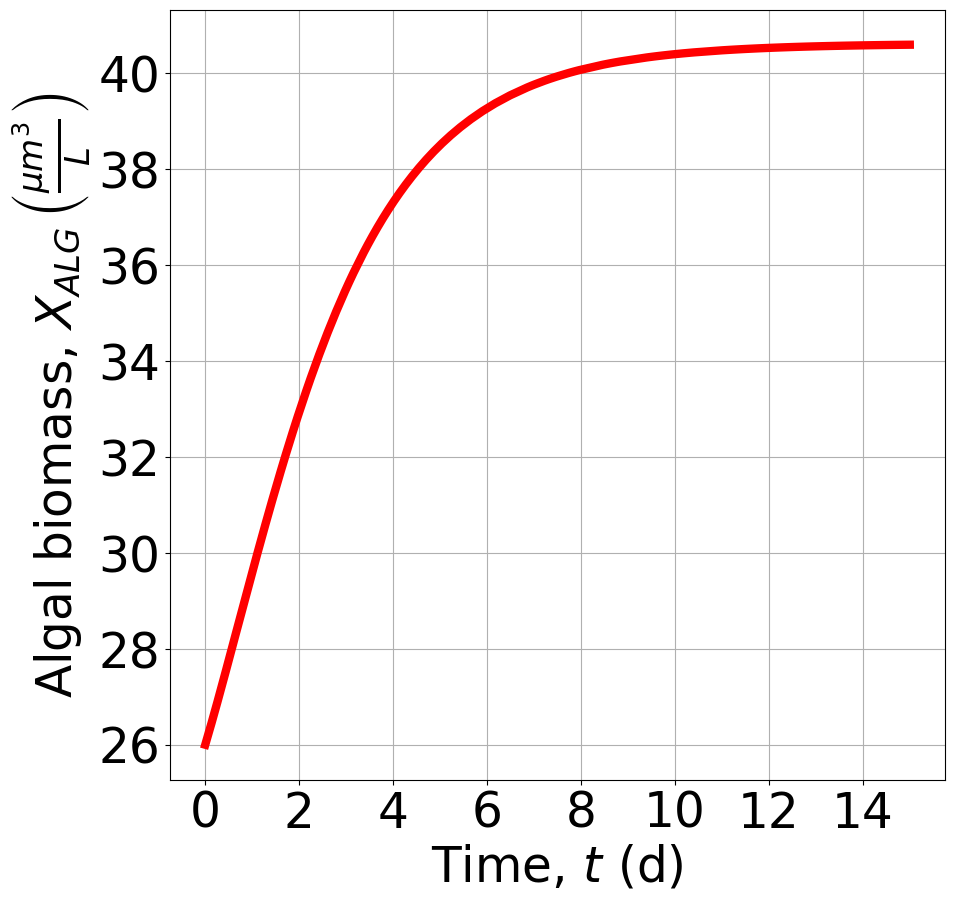

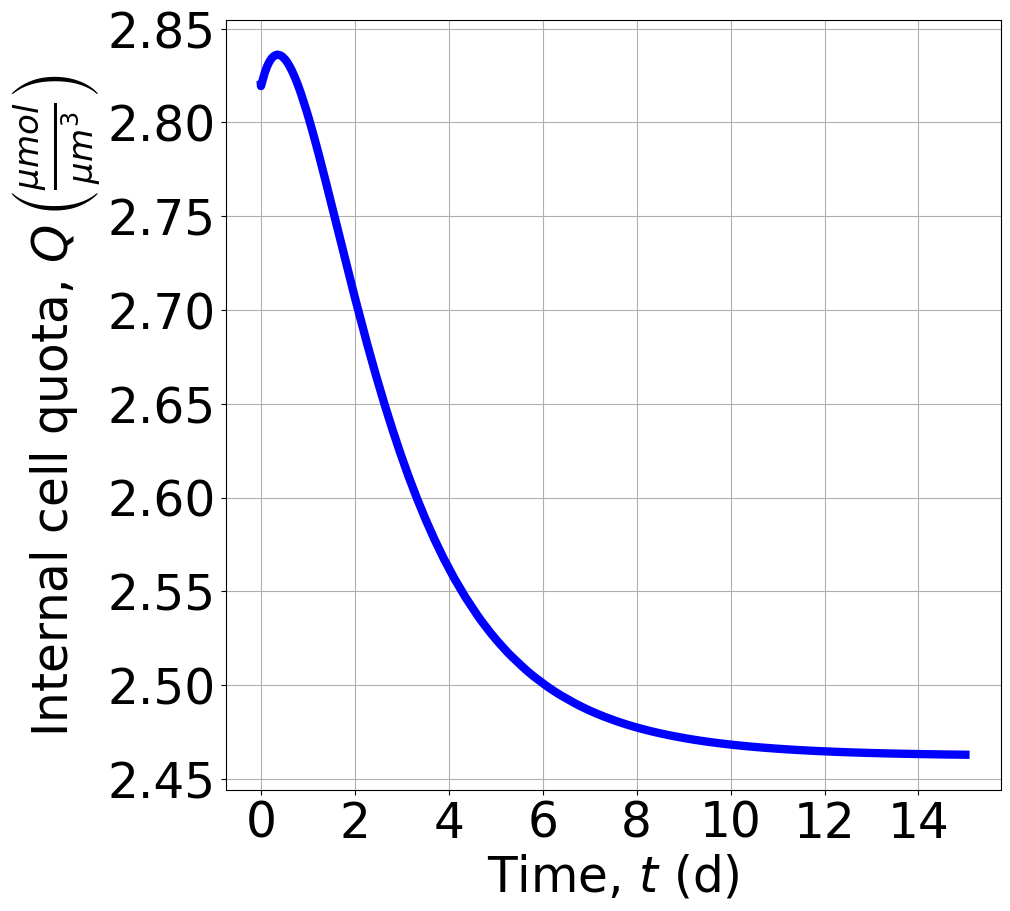

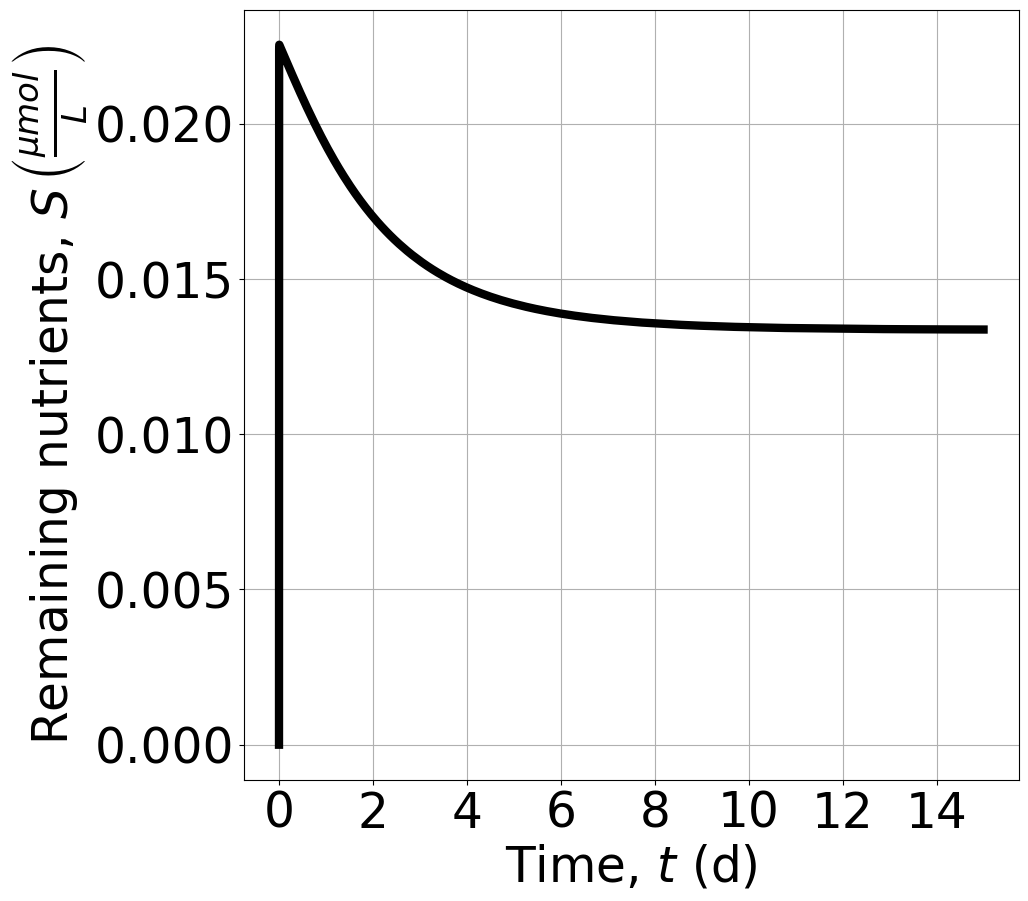

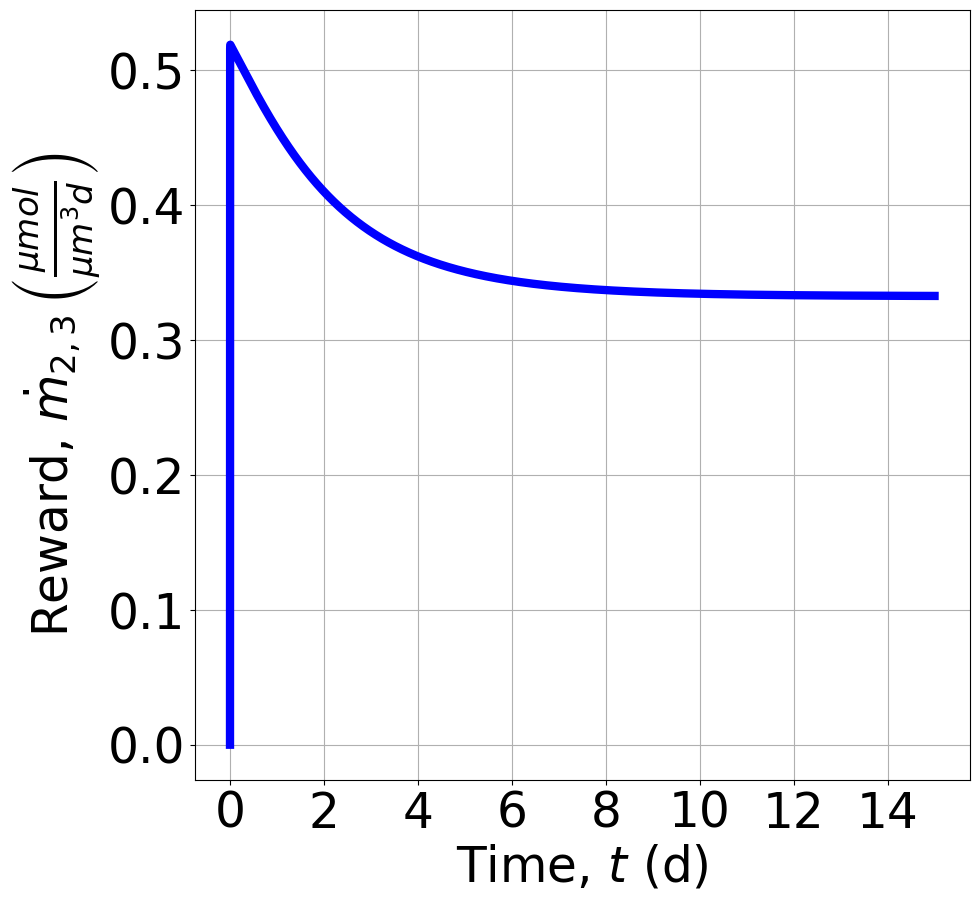

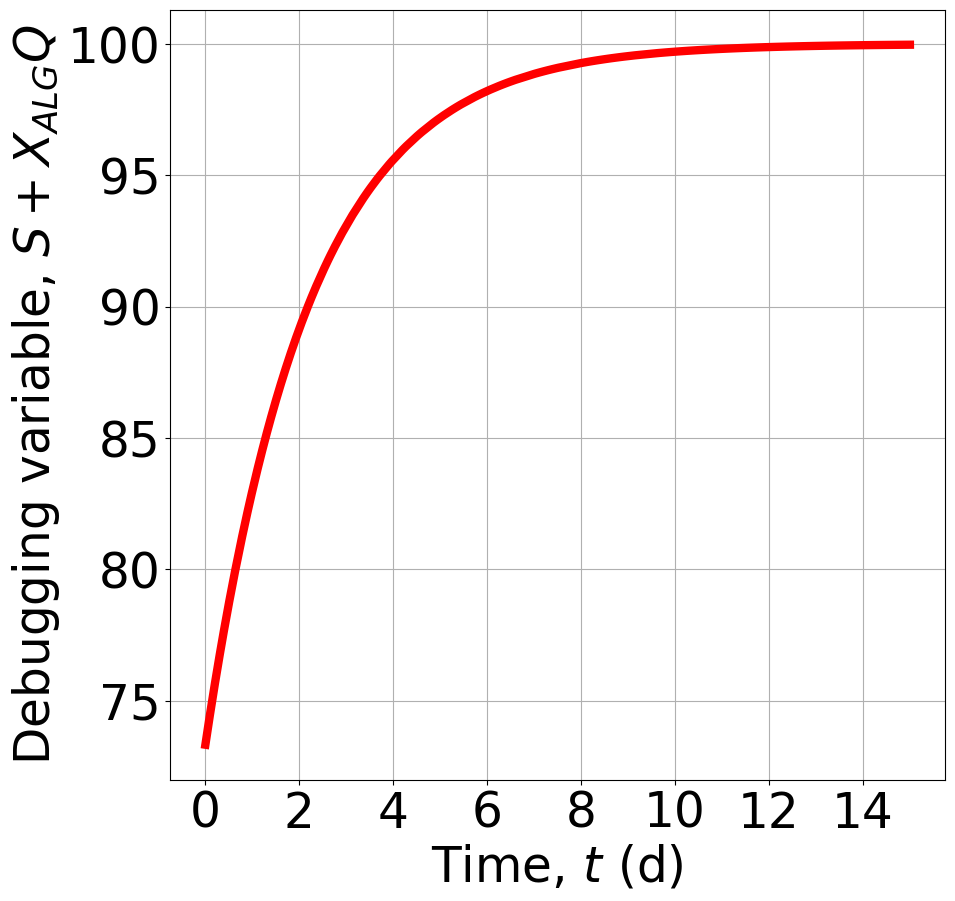

In [ ]:
env = microalgaeDroop()

obs, _ = env.reset()

print(obs)
print(env.observation_space)
print(env.action_space)
#print(env.action_space.sample())

I_bar = 50
I_bar = ((I_bar-env.I_min)/(env.I_max-env.I_min))*(1-(-1))+(-1) # normalize to be in [-1,1] before use
I = [I_bar] # between '[]' because step() expects this shape

n_steps = 300000

# For plotting:
vector_t = -np.ones(n_steps+1)
vector_X_ALG = -np.ones(n_steps+1)
vector_Q = -np.ones(n_steps+1)
vector_S = -np.ones(n_steps+1)
vector_reward = -np.ones(n_steps)
vector_t[0] = 0
vector_X_ALG[0] = X_ALG_ini
vector_Q[0] = Q_ini
vector_S[0] = S_ini

for step in range(n_steps):
    obs, reward, truncated, terminated, info = env.step(I)

    # For plotting:
    vector_t[step+1] = vector_t[step] + env.dt
    vector_X_ALG[step+1] = obs[0]
    vector_Q[step+1] = obs[1]
    vector_S[step+1] = obs[2]
    vector_reward[step] = reward

env.render()